In [1]:
"""
Use metropolis method to calculate:

<x> = integral(x*e^-x) / integral(e^-x)

Here P(x) = e^-x.
Use probability P(x) = 0 for x < 0.
Try different values of the parameter delta in range(0.001, 10).
Study sigma/sqrt(N) and compare with the actual difference to the exact asnwer.
(note: N_0 is not critical when x_0 = 0).

"""

print() # just to clear console log below

In [11]:
import numpy as np
from alive_progress import alive_bar
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import matplotlib
rc('animation', html='jshtml')
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [10, 7]

In [3]:
def my_Metropolis(p, z0, sigma = 1, delta = 1, n_samples=100, burn_in=0, m=1):
    # p is the probability function
    # z0 is the intial value
    # brun_in is the number of skipped values
    # m is number of iterations before recording?
    
    # Pre-allocate memory for samples (much more efficient than using append)
    samples = np.zeros(n_samples)

    # Store initial value
    samples[0] = z0
    z = z0
    # Compute the current likelihood
    l_cur = p(z)

    # Counter
    iter = 0
    # Total number of iterations to make to achieve desired number of samples
    iters = (n_samples * m) + burn_in

    # Sample outside the for loop
    #innov = np.random.normal(loc=0.0, scale=sigma, size=iters)
    innov = np.random.uniform(low=-delta, high=delta, size=iters)
    u = np.random.rand(iters)

    while iter < iters:
        # Random walk innovation on z
        cand = z + innov[iter]

        # Compute candidate likelihood
        l_cand = p(cand)

        # Accept or reject candidate
        if l_cand / l_cur > u[iter]:
            z = cand
            l_cur = l_cand

        # Only keep iterations after burn-in and for every m-th iteration
        if iter > burn_in and iter % m == 0:
            samples[(iter - burn_in) // m] = z

        iter += 1

    return samples

In [5]:
def p(x):
    if x < 0:
        return 0
    else:
        return np.exp(-x)

def f(x):
    return x

N0 = 10**5
x0 = 0
n_samples = 10**6
iterations = 1

delta_list = np.linspace(0.01, 10, 25)

se_list = np.zeros(len(delta_list))
avg_list = np.zeros(len(delta_list))

with alive_bar(len(delta_list), title="Processing standard error") as bar:
    for i in range(len(delta_list)):
        avg_temp = np.zeros(iterations)
        se_temp = np.zeros(iterations)
        for j in range(iterations):
            samples = my_Metropolis(p, x0, delta = delta_list[i], n_samples=n_samples, burn_in=N0)
            avg_temp[j] = 1/len(samples) * np.sum(f(samples))
            sigma = 1/len(samples) * np.sum(f(samples)**2) - avg_temp[j]**2
            se_temp[j] = sigma/np.sqrt(len(samples))

        avg_list[i] = np.average(avg_temp)
        se_list[i] = np.average(se_temp)

        bar()

Processing standard error |████████████████████████████████████████| 25/25 [100%] in 1:27.0 (0.29/s)


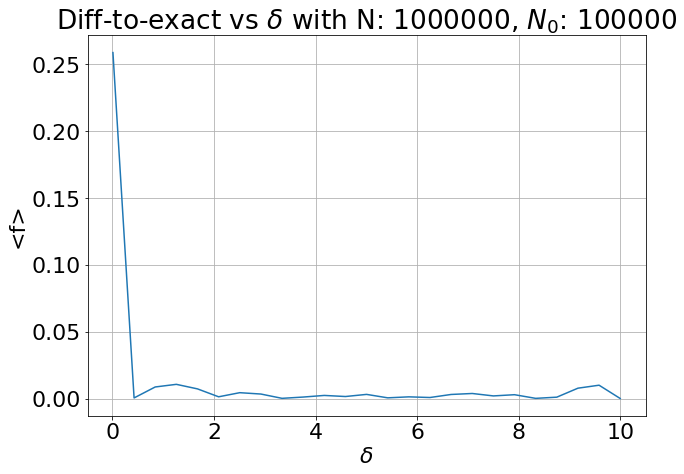

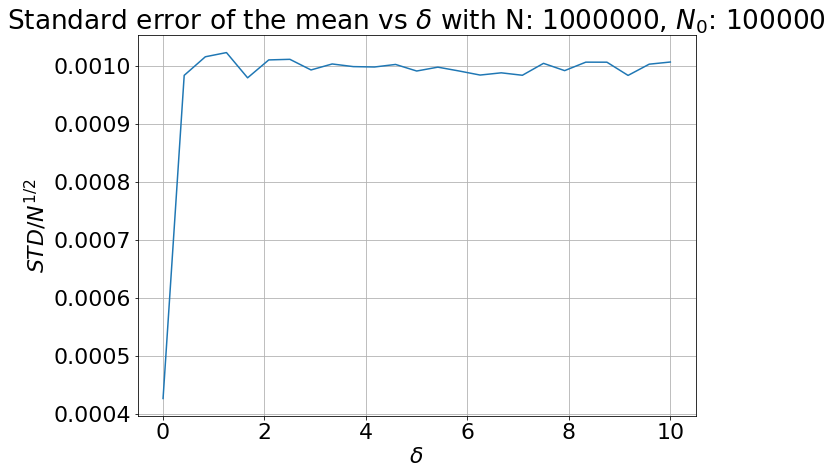

In [12]:
plt.figure()
plt.title( f"Diff-to-exact vs $\delta$ with N: {n_samples}, $N_0$: {N0}")
plt.plot(delta_list, abs(1-avg_list), label="diff-to-exact")
#plt.plot(delta_list, np.ones(len(delta_list)), label="Exact value")
plt.xlabel(r'$\delta$')
plt.grid()
plt.ylabel('<f>')
plt.show()

plt.figure()
plt.title(f"Standard error of the mean vs $\delta$ with N: {n_samples}, $N_0$: {N0}")
plt.plot(delta_list, se_list, label="$\sigma/N^{1/2}$")
plt.xlabel(r'$\delta$')
plt.ylabel('$STD/N^{1/2}$')
plt.grid()
#plt.legend()
plt.show()

### Real answer is 1 / 1 = 1

In [32]:
# Study sigma/sqrt(N)

N_list = np.linspace(1, 1000, 1000)
N_list = np.insert(N_list, 1, np.linspace(2,100, 40))
N_list = list(map(int, N_list))

se_list2 = np.zeros(len(N_list))
avg_list2 = np.zeros(len(N_list))

with alive_bar(len(N_list), title="Processing") as bar:
    for i in range(len(N_list)):
        avg_temp = np.zeros(iterations)
        se_temp = np.zeros(iterations)
        
        for j in range(iterations):
            samples = my_Metropolis(p, x0, delta = 1, n_samples=N_list[i], burn_in=N0)
            avg_temp[j] = 1/len(samples) * np.sum(f(samples))
            sigma = 1/len(samples) * np.sum(f(samples)**2) - avg_temp[j]**2
            se_temp[j] = sigma/np.sqrt(len(samples))

        avg_list2[i] = np.average(avg_temp)
        se_list2[i] = np.average(se_temp)

        bar()



Processing |████████████████████████████████████████| 1040/1040 [100%] in 43.2s (24.07/s)


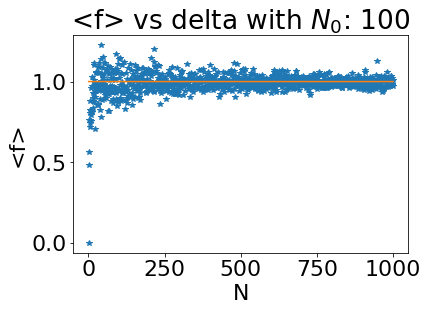

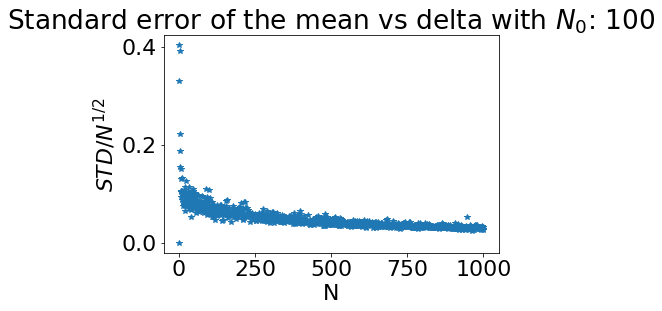

In [34]:
plt.figure()
plt.title( f"<f> vs delta with $N_0$: {N0}")
plt.plot(N_list, avg_list2, '*')
plt.plot(N_list, np.ones(len(N_list)), label="Exact value")
plt.xlabel('N')
plt.ylabel('<f>')
plt.show()

plt.figure()
plt.title(f"Standard error of the mean vs delta with $N_0$: {N0}")
plt.plot(N_list, se_list2,'*')
plt.xlabel('N')
plt.ylabel('$STD/N^{1/2}$')
plt.show()

In [1]:
N = 1000
x0 = 12
iterations = 50

N0_list = np.linspace(1, N-1, 250)
N0_list = list(map(int, N0_list))

se_list2 = np.zeros(len(N0_list))
avg_list2 = np.zeros(len(N0_list))

with alive_bar(len(N0_list), title="Processing") as bar:
    for i in range(len(N0_list)):
        avg_temp = np.zeros(iterations)
        se_temp = np.zeros(iterations)
        
        for j in range(iterations):
            samples = my_Metropolis(p, x0, delta = 4, n_samples=N, burn_in=N0_list[i])
            avg_temp[j] = 1/len(samples) * np.sum(f(samples))
            sigma = 1/len(samples) * np.sum(f(samples)**2) - avg_temp[j]**2
            se_temp[j] = sigma/np.sqrt(len(samples))

        avg_list2[i] = np.average(avg_temp)
        se_list2[i] = np.average(se_temp)

        bar()

NameError: name 'np' is not defined

In [ ]:
plt.figure()
plt.title( f"<f> vs $N_0$ with $N$: {N}, $x_0$: {x0}")
plt.plot(N0_list, avg_list2, '-', label="Simulated value")
plt.plot(N0_list, np.ones(len(N0_list)), label="Exact value")
plt.xlabel('$N_0$')
plt.ylabel('<f>')
plt.ylim([0.8, 1.2])
plt.legend()
plt.show()

plt.figure()
plt.title(f"Standard error of the mean vs $N_0$ with $N$: {N}, $x_0$: {x0}")
plt.plot(N0_list, se_list2,'-')
plt.xlabel('$N_0$')
plt.ylabel('$STD/N^{1/2}$')
plt.show()